# Age-centered Analysis
Throughout this script, you can analyze the user profiles in the dataset based on users' interaction patterns. Adapt the variables below to adapt to different age groupings or datasets.

In [1]:
dataset = 'ml' # 'ml', 'mlhd', or 'bx'
weighted = True
age_type = 'defined_ages' # 'defined_ages', 'even_age_groups', 'finegrained_age', 'finegrained_child_ages', 'all_ages

In [2]:

import os
import ast
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np


In [3]:
from dotenv import load_dotenv
from pathlib import Path
env_path = Path('..') / 'config.env'
load_dotenv(dotenv_path=env_path)
dataset_dir = os.getenv("dataset_directory")

import utils.age_processing as ap
import utils.genre_processing as gp

In [4]:
ages_sort = ap.get_sorted_ages(dataset, age_type, simplified=True)
ages_sort

['< 18', '18-49', '50+']

In [5]:
genres = []

if dataset == 'ml':
    data_dir = dataset_dir + '/processed/movielens-1m'
    with open('../utils/ML_genres.txt', 'r') as f:
        for line in f:
            genres.append(line.strip())
elif dataset == 'mlhd':
    data_dir = dataset_dir + '/processed/MLHD_sampled_filtered'
    with open('../utils/MLHD_genres.txt', 'r') as f:
        for line in f:
            genres.append(line.strip())
elif dataset == 'bx':
    data_dir = dataset_dir + '/processed/Book-Crossing'
    with open('../utils/BX_genres.txt', 'r') as f:
        for line in f:
            genres.append(line.strip())

In [6]:
user_profile_stats_path = data_dir + f'/user_profile_stats{"_weighted" if weighted else ""}.tsv'
user_path = data_dir + '/users.tsv'
interactions_path = data_dir + '/interactions.tsv.bz2'

#users = pd.read_csv(user_path, sep='\t')
user_stats = pd.read_csv(user_profile_stats_path, sep='\t')
user_stats['normalized_genre_distribution'] = user_stats['normalized_genre_distribution'].apply(ast.literal_eval)

user_stats['age_group'] = user_stats['age'].apply(lambda x: ap.age_group(x, dataset, age_type, simplified=True))
user_stats['age_group'] = pd.Categorical(user_stats['age_group'], categories=ages_sort, ordered=True)

grouped_user_stats = user_stats.groupby('age_group')

C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\1095842299.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_user_stats = user_stats.groupby('age_group')


In [7]:
user_stats.columns

Index(['user_id', 'age', 'num_interactions', 'num_unique_items',
       'normalized_genre_distribution', 'avg_popularity',
       'avg_normalized_popularity', 'avg_age_group_popularity',
       'avg_normalized_age_group_popularity', 'age_group'],
      dtype='object')

In [8]:
genres = []

if dataset == 'mlhd':
    genres = gp.MLHD_genres
elif dataset == 'ml':
    genres = gp.ML_genres
elif dataset == 'bx':
    genres = gp.BX_genres
    


age_genre_profiles = pd.DataFrame(columns=('age_group', 'genre_distribution'))
print("Calculating genre distributions for each age group...")

for age, group in grouped_user_stats:
    genre_sum = {}
    num_users = len(group)
    for i,user in group.iterrows():

        for user_genre, value in user['normalized_genre_distribution'].items():
            if user_genre in genre_sum:
                genre_sum[user_genre] += value
            else:
                genre_sum[user_genre] = value
       
    genre_avg = {genre: g_sum / num_users for genre, g_sum in genre_sum.items()}
    if age in age_genre_profiles['age_group'].values:
        age_genre_profiles.loc[age_genre_profiles['age_group'] == age, 'genre_distribution'] = [genre_avg]
        print("this should not happen") # test statement
    else:
        age_genre_profiles = pd.concat([age_genre_profiles, pd.DataFrame({'age_group': [age], 'genre_distribution': [genre_avg]})], ignore_index=True)



age_genre_profiles['genre_distribution'] = age_genre_profiles['genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset))

user_stats['genre_distribution'] = user_stats['normalized_genre_distribution'].apply(lambda x: gp.genre_dict_to_list(x, dataset))

grouped_user_stats = user_stats.groupby('age_group')

age_genre_profiles['age_group'] = pd.Categorical(age_genre_profiles['age_group'], 
                                            categories=ages_sort, 
                                            ordered=True)

    
age_genre_profiles.sort_values('age_group', inplace=True)

Calculating genre distributions for each age group...


C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\2617787729.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_user_stats = user_stats.groupby('age_group')


# Plotting and Computing Stats about the users

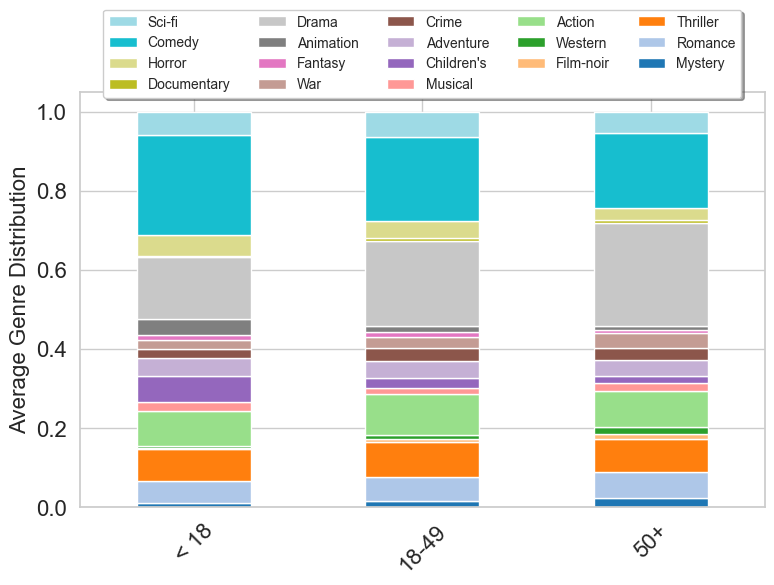

In [9]:
# Compute and plot the average genre distribution for each age group

plot_genres = [genre.capitalize() for genre in genres]
# Prepare data for stacked bar plot
genre_data = pd.DataFrame(age_genre_profiles['genre_distribution'].tolist(), index=age_genre_profiles['age_group'], columns=plot_genres)




# Plot stacked bar chart
plt.figure(figsize=(8, 6))
sns.set(style='whitegrid')
genre_data.plot(kind='bar', stacked=True, cmap='tab20', ax=plt.gca())
plt.xlabel('')
plt.ylabel('Average Genre Distribution', fontsize=16)
handles, labels = plt.gca().get_legend_handles_labels() 
labels = ['/'.join([l.capitalize() for l in label.split('_')]) for label in labels]
#plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.legend(handles[::-1], labels[::-1], loc='lower center', bbox_to_anchor=(0.5, 0.97),
          ncol=5, fancybox=True, shadow=True, fontsize=10)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig(f'Results/genre_distribution_{dataset}_{age_type}.pdf', bbox_inches='tight', pad_inches = 0)
plt.show()

Calculating average Jensen-Shannon Divergence within age groups...
Processing age group: < 18
Processing age group: 18-49


C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\420802812.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  intra_group_js_divergences = pd.concat([intra_group_js_divergences, pd.DataFrame({'age_group': [age], 'average_js_divergence': [average_js_divergence]})], ignore_index=True)


Processing age group: 50+


C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\420802812.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=intra_group_js_divergences, x='age_group', y='average_js_divergence', palette='tab20')


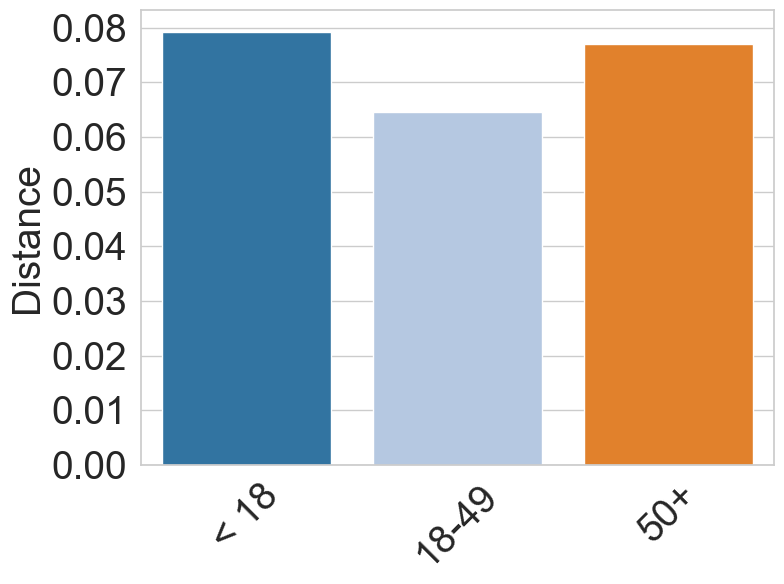

In [10]:
# Compute the intra-group Jensen-Shannon Divergence (JSD) for each age group

epsilon = 1e-10
print("Calculating average Jensen-Shannon Divergence within age groups...")
# Initialize a DataFrame to store the average JSD values for each age group
intra_group_js_divergences = pd.DataFrame(columns=['age_group', 'average_js_divergence'])

from scipy.spatial.distance import jensenshannon

# Iterate over each age group
for age, group in grouped_user_stats:
    print(f"Processing age group: {age}")
    num_users = len(group)
    js_divergences = []
    # Transform genre distributions for vectorized operations
    genre_distributions = np.array([np.array(user['genre_distribution']) + epsilon for i, user in group.iterrows()])
    
    avg_age_genre_distribution = np.mean(genre_distributions, axis=0)
    
    # Calculate pairwise JSD for all users within the same age group
    pairwise_jsd = [jensenshannon(avg_age_genre_distribution, user_genre_distribution)**2 for user_genre_distribution in genre_distributions]

    pairwise_jsd = [0 if np.isnan(jsd) else jsd for jsd in pairwise_jsd]
            
    # Average the pairwise JSDs
    average_js_divergence = np.mean(pairwise_jsd) if len(pairwise_jsd) > 0 else 0
    intra_group_js_divergences = pd.concat([intra_group_js_divergences, pd.DataFrame({'age_group': [age], 'average_js_divergence': [average_js_divergence]})], ignore_index=True)

# Sort the DataFrame by age
intra_group_js_divergences['age_group'] = pd.Categorical(intra_group_js_divergences['age_group'], categories=ages_sort, ordered=True)
intra_group_js_divergences.sort_values('age_group', inplace=True)

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(data=intra_group_js_divergences, x='age_group', y='average_js_divergence', palette='tab20')
plt.ylabel('Distance', fontsize=28)
plt.xlabel('')
plt.xticks(rotation=45, fontsize=28)
plt.yticks(fontsize=28)
plt.tight_layout()
plt.savefig(f'Results/in_group_jsd_{dataset}_{age_type}.pdf', bbox_inches='tight', pad_inches = 0)
plt.show()

Calculating Jensen-Shannon Divergence between age groups...


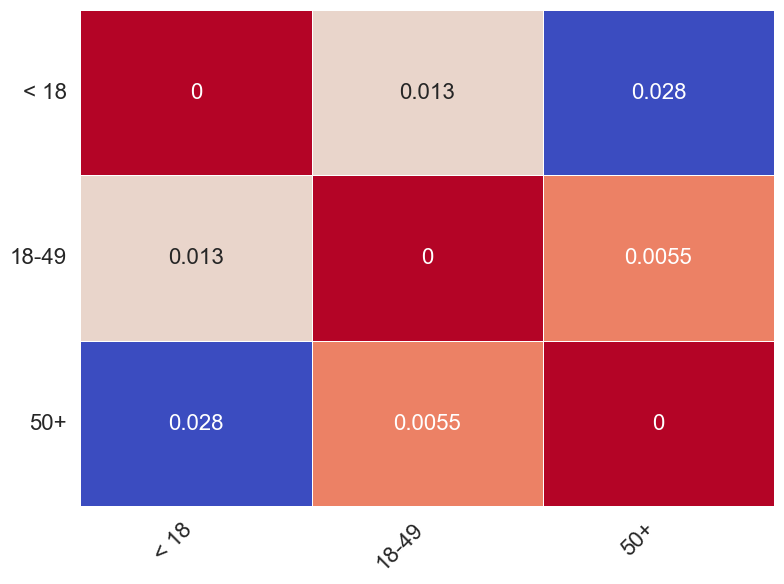

In [11]:
# Compute the age preference deviations between age groups

print("Calculating Jensen-Shannon Divergence between age groups...")
inter_group_js_divergences = {}
epsilon = 1e-10

for i, row1 in age_genre_profiles.iterrows():
    age1 = row1['age_group']
    genre_distribution1 = np.array(row1['genre_distribution']) + epsilon
    
    for j, row2 in age_genre_profiles.iterrows():
        age2 = row2['age_group']
        genre_distribution2 = np.array(row2['genre_distribution']) + epsilon

        # Jensen-Shannon Divergence
        js_div = jensenshannon(genre_distribution1, genre_distribution2)**2
        inter_group_js_divergences[(age1, age2)] = js_div

ages = age_genre_profiles['age_group'].unique()  

heatmap_data = pd.DataFrame(index=ages, columns=ages)
for (age1, age2), js_div in inter_group_js_divergences.items():
    #print(f"Jensen-Shannon Divergence between age {age1} and age {age2}: {js_divergence}")
    heatmap_data.at[age1, age2] = js_div
    heatmap_data.at[age2, age1] = js_div  # Ensure symmetry
    
heatmap_data = heatmap_data.astype(float)
# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(heatmap_data, annot=True, cmap="coolwarm_r", linewidths=0.5, cbar=False, annot_kws={"size": 16})
#plt.title("Jensen-Shannon Divergence Between Age Groups")

plt.xlabel("")
plt.ylabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=16)  # Set rotation to 0 for horizontal

plt.tight_layout()
plt.savefig(f'Results/age_preference_deviations_{dataset}_{age_type}.pdf', bbox_inches='tight', pad_inches = 0)
plt.show()

In [12]:
#### This was used in the original study; not accurate anymore due to potential violations of the assumptions of ANOVA

if not age_type == 'defined_ages':
    raise ValueError("This analysis is only valid for defined_ages age type.")
else:
    print("Performing ANOVA analysis on genre distributions...")

    genres = [genre.replace("'", "").replace("-", "").replace(" ", "") for genre in genres]
    genre_df = pd.DataFrame(user_stats['genre_distribution'].apply(np.array).tolist())
    genre_df.columns = genres
    genre_df = genre_df.astype(float)    

    # Combine with the original DataFrame
    genre_df = pd.concat([user_stats['age_group'], genre_df], axis=1)
    

    # Drop nma users
    genre_df = genre_df[~genre_df['age_group'].isin([ages_sort[-1]])]
    genre_df['age_group'] = genre_df['age_group'].astype(str)

    
    #print(genre_df.head(n=3))
    from statsmodels.multivariate.manova import MANOVA
    
    # # Fit the MANOVA model
    manova = MANOVA.from_formula(' + '.join(genres) + ' ~ age_group', data=genre_df)
    manova_results = manova.mv_test()



    
    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    from statsmodels.stats.multicomp import pairwise_tukeyhsd

    # Melt the DataFrame to long format for ANOVA
    melted_df = genre_df.melt(id_vars=['age_group'], value_vars=genre_df.columns, var_name='genre', value_name='value')


    import statsmodels.api as sm
    from statsmodels.formula.api import ols

    # Perform ANOVA for each genre
    anova_results = {}
    for genre in genre_df.drop('age_group', axis=1).columns:
        model = ols(f'{genre} ~ age_group', data=genre_df).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[genre] = anova_table

    # Print ANOVA results for each genre
    for genre, result in anova_results.items():
        if result['PR(>F)'].iloc[0] < 0.05:
            print(f'ANOVA results for {genre}:')
            print(result)
            print('\n')

    # Tukey's HSD test for each genre
    tukey_results = {}
    for genre in genres:
        tukey = pairwise_tukeyhsd(endog=melted_df[melted_df['genre'] == genre]['value'],
                                groups=melted_df[melted_df['genre'] == genre]['age_group'],
                                alpha=0.01)
        tukey_results[genre] = tukey

    print('sigificant Genres')
    # Print Tukey's HSD results for each genre
    for genre, result in tukey_results.items():
        if result.reject.any():
            
            print(f'Tukey HSD results for {genre}:')
            print(result)
            print('\n')

    print('non-significant Genres')
    for genre, result in tukey_results.items():
        if not result.reject.any():
            print(f'Tukey HSD results for {genre}:')
            print(result)
            print('\n')
        

Performing ANOVA analysis on genre distributions...
ANOVA results for Mystery:
             sum_sq      df          F    PR(>F)
age_group  0.004358     1.0  14.222947  0.000164
Residual   1.581712  5162.0        NaN       NaN


ANOVA results for Thriller:
              sum_sq      df         F    PR(>F)
age_group   0.014410     1.0  5.247201  0.022022
Residual   14.176222  5162.0       NaN       NaN


ANOVA results for FilmNoir:
             sum_sq      df          F    PR(>F)
age_group  0.005428     1.0  14.682653  0.000129
Residual   1.908192  5162.0        NaN       NaN


ANOVA results for Western:
             sum_sq      df          F    PR(>F)
age_group  0.004419     1.0  11.132622  0.000854
Residual   2.048917  5162.0        NaN       NaN


ANOVA results for Action:
              sum_sq      df         F    PR(>F)
age_group   0.040342     1.0  7.837091  0.005138
Residual   26.571978  5162.0       NaN       NaN


ANOVA results for Musical:
             sum_sq      df          F  

In [13]:
# Compute the appropriate statistical test for the dataset to observe differences in genre distributions between age groups

from scipy.stats import kruskal, mannwhitneyu
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import pandas as pd

if not age_type == 'defined_ages':
    raise ValueError("This analysis is only valid for defined_ages age type.")
else:
    genres = [genre.replace("'", "").replace("-", "").replace(" ", "") for genre in genres]
    genre_df = pd.DataFrame(user_stats['genre_distribution'].apply(np.array).tolist())
    genre_df.columns = genres
    genre_df = genre_df.astype(float)    

    # Combine with the original DataFrame
    genre_df = pd.concat([user_stats['age_group'], genre_df], axis=1)
    

    # Drop nma users
    # genre_df = genre_df[~genre_df['age_group'].isin([ages_sort[-1]])]
    # genre_df['age_group'] = genre_df['age_group'].astype(str)
    
        
    # Perform Kruskal–Wallis test for each genre
    kruskal_results = []
    significant_genres = []

    for genre in genre_df.drop('age_group', axis=1).columns:
        grouped = [group[genre].values for _, group in genre_df.groupby('age_group')]
        stat, p = kruskal(*grouped)
        kruskal_results.append({'genre': genre, 'H-stat': stat, 'p-value': p})
        if p < 0.05:
            significant_genres.append(genre)

    kruskal_df = pd.DataFrame(kruskal_results).sort_values('p-value')

    # Print significant Kruskal–Wallis results
    print('Significant Kruskal–Wallis genres (p < 0.05):')
    print(kruskal_df[kruskal_df['p-value'] < 0.05])
    print('\n')

    # Pairwise Mann–Whitney U tests for significant genres
    posthoc_results = []

    for genre in significant_genres:
        for g1, g2 in combinations(genre_df['age_group'].unique(), 2):
            data1 = genre_df[genre_df['age_group'] == g1][genre]
            data2 = genre_df[genre_df['age_group'] == g2][genre]
            stat, p = mannwhitneyu(data1, data2, alternative='two-sided')
            posthoc_results.append({
                'genre': genre,
                'group1': g1,
                'group2': g2,
                'U-stat': stat,
                'p-raw': p
            })

    # Multiple testing correction (FDR)
    posthoc_df = pd.DataFrame(posthoc_results)
    posthoc_df['p-corrected'] = multipletests(posthoc_df['p-raw'], method='fdr_bh')[1]

    # Split into significant and non-significant
    print('Significant Mann–Whitney U posthoc comparisons (FDR < 0.05):')
    print(posthoc_df[posthoc_df['p-corrected'] < 0.05])
    print('\n')

    print('Non-significant Mann–Whitney U posthoc comparisons:')
    print(posthoc_df[posthoc_df['p-corrected'] >= 0.05])

Significant Kruskal–Wallis genres (p < 0.05):
          genre      H-stat       p-value
12    Animation  235.285979  8.096529e-52
10          War  201.777566  1.529531e-44
7     Childrens  176.873606  3.911870e-39
13        Drama  150.082817  2.569983e-33
4       Western  120.904159  5.571798e-27
0       Mystery  106.905551  6.105970e-24
11      Fantasy   87.773094  8.715952e-20
17        SciFi   84.919586  3.630332e-19
3      FilmNoir   83.279528  8.242904e-19
15       Horror   79.659686  5.036387e-18
16       Comedy   78.703551  8.123459e-18
5        Action   78.460138  9.174821e-18
9         Crime   76.248717  2.772053e-17
2      Thriller   24.232412  5.470141e-06
1       Romance   23.180842  9.254311e-06
8     Adventure   21.605130  2.034725e-05
14  Documentary   17.311589  1.741150e-04
6       Musical   15.209619  4.980504e-04


Significant Mann–Whitney U posthoc comparisons (FDR < 0.05):
          genre group1 group2     U-stat         p-raw   p-corrected
0       Mystery   < 18  

C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\1088283165.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = [group[genre].values for _, group in genre_df.groupby('age_group')]


# Popularity Analysis

In [14]:
# Compute an analysis of the popularity of items in the user profiles


for variable in ['num_interactions', 'num_unique_items', 'avg_popularity', 'avg_normalized_popularity', 'avg_age_group_popularity', 'avg_normalized_age_group_popularity']:
    # Paired t-test for each variable
    print(f'Mean {variable} for each age group:')
    print(user_stats.groupby('age_group')[variable].mean().round(3))
    for age_group_1 in ages_sort:
        for age_group_2 in ages_sort:
            if age_group_1 != age_group_2:
                group_1 = user_stats[user_stats['age_group'] == age_group_1][variable]
                group_2 = user_stats[user_stats['age_group'] == age_group_2][variable]

                # Perform independent t-test
                t_stat, p_value = ttest_ind(group_1, group_2, equal_var=False)
                print(f"Independent t-test for {variable} between {age_group_1} and {age_group_2}:")
                print(f"t-statistic: {t_stat}, p-value: {p_value}")
                print('\n')
                
    print("\n\n")
    print("--------------------------------------------------")
    print("\n\n")
                

Mean num_interactions for each age group:
age_group
< 18     122.568
18-49    174.368
50+      127.021
Name: num_interactions, dtype: float64
Independent t-test for num_interactions between < 18 and 18-49:
t-statistic: -5.368945037434021, p-value: 1.7335276128525498e-07


Independent t-test for num_interactions between < 18 and 50+:
t-statistic: -0.41730511557552, p-value: 0.6766879253860965


Independent t-test for num_interactions between 18-49 and < 18:
t-statistic: 5.368945037434021, p-value: 1.7335276128525498e-07


Independent t-test for num_interactions between 18-49 and 50+:
t-statistic: 7.80160965484385, p-value: 1.1813496415156672e-14


Independent t-test for num_interactions between 50+ and < 18:
t-statistic: 0.41730511557552, p-value: 0.6766879253860965


Independent t-test for num_interactions between 50+ and 18-49:
t-statistic: -7.80160965484385, p-value: 1.1813496415156672e-14





--------------------------------------------------



Mean num_unique_items for each age g

C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\1461750226.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(user_stats.groupby('age_group')[variable].mean().round(3))


Independent t-test for avg_popularity between < 18 and 18-49:
t-statistic: -3.7547572639477327, p-value: 0.00021766157908755497


Independent t-test for avg_popularity between < 18 and 50+:
t-statistic: 0.6423857240430908, p-value: 0.5210728930727703


Independent t-test for avg_popularity between 18-49 and < 18:
t-statistic: 3.7547572639477327, p-value: 0.00021766157908755497


Independent t-test for avg_popularity between 18-49 and 50+:
t-statistic: 8.79255331635062, p-value: 4.805739626224873e-18


Independent t-test for avg_popularity between 50+ and < 18:
t-statistic: -0.6423857240430908, p-value: 0.5210728930727703


Independent t-test for avg_popularity between 50+ and 18-49:
t-statistic: -8.79255331635062, p-value: 4.805739626224873e-18





--------------------------------------------------



Mean avg_normalized_popularity for each age group:
age_group
< 18     0.263
18-49    0.282
50+      0.260
Name: avg_normalized_popularity, dtype: float64
Independent t-test for avg_norma

C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\1727309166.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=user_stats, x='age_group', y='avg_normalized_popularity', palette='tab10')


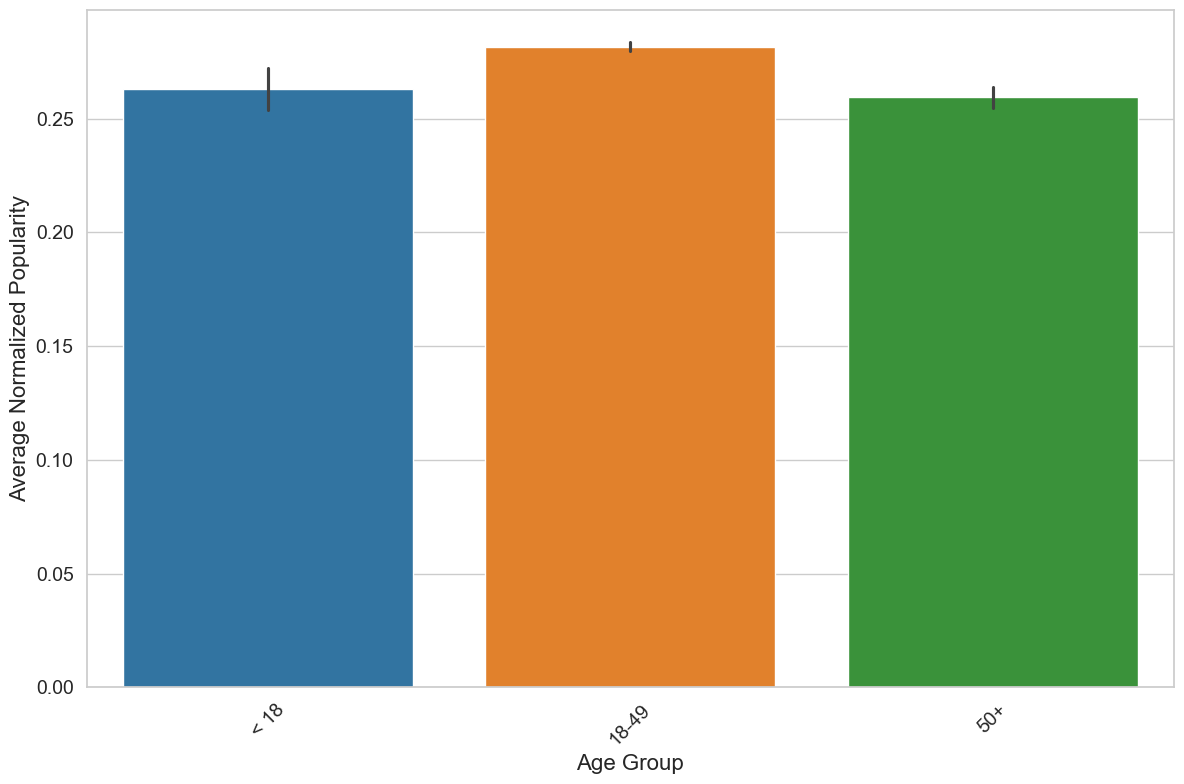

In [15]:
# Plot the average popularity for each age group

plt.figure(figsize=(12, 8))
sns.barplot(data=user_stats, x='age_group', y='avg_normalized_popularity', palette='tab10')
plt.xlabel('Age Group', fontsize=16)
plt.ylabel('Average Normalized Popularity', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

# Mainstream/Child Deviations

Calculating the deviation of each user from the mainstream and child profile...


C:\Users\rungruh\AppData\Local\Temp\ipykernel_6680\996791579.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  js_grouped = js_results_df.groupby('age').mean()


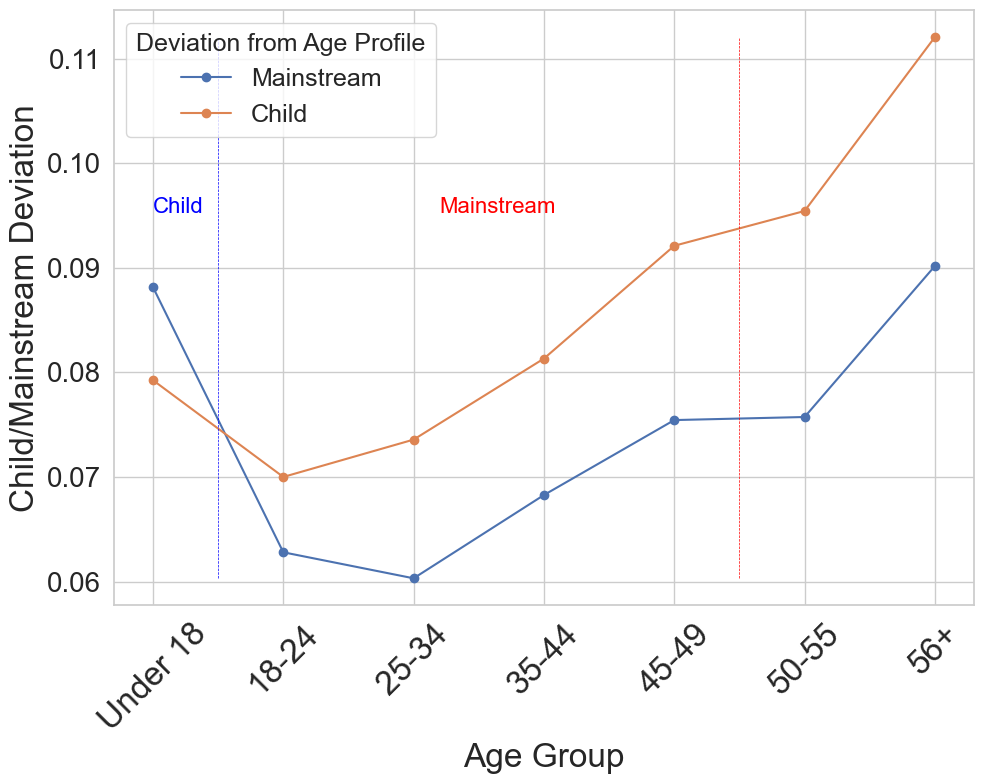

In [16]:
# Compute the average deviation of each user from the mainstream and child profile, aggregated by age

print("Calculating the deviation of each user from the mainstream and child profile...")
from scipy.spatial.distance import jensenshannon


def plot_child_mainstream_deviation(stats):
    ages = stats['age'].unique()
    if age_type != 'defined_ages':
        raise ValueError("This analysis is only valid for defined_ages age type.")
    mainstream_distribution = stats[stats['age_group'] == ages_sort[1]]['genre_distribution'].apply(np.array).mean(axis=0)
    child_distribution = stats[stats['age_group'] == ages_sort[0]]['genre_distribution'].apply(np.array).mean(axis=0)
    
    js_results_df = pd.DataFrame()

    stats.sort_values('age', inplace=True)
    for age_group, group in stats.groupby('age'):

        js_df = pd.DataFrame()
        js_df['js_mainstream'] = None
        js_df['js_child'] = None
        js_df['user_id'] = None
        js_df['age'] = None
        for i, row in group.iterrows():
            user_distribution = np.array(row['genre_distribution'], dtype=float)
            js_mainstream = jensenshannon(user_distribution, mainstream_distribution)**2
            js_child = jensenshannon(user_distribution, child_distribution)**2

            if np.isnan(js_mainstream):
                js_mainstream = 0
            if np.isnan(js_child):
                js_child = 0
            js_df.at[i, f'js_mainstream'] = js_mainstream
            js_df.at[i, f'js_child'] = js_child
            js_df.at[i, 'user_id'] = row['user_id']
            js_df.at[i, 'age'] = age_group
            
        
        js_results_df = pd.concat([js_results_df, js_df], axis=0)

    all_ages = ap.get_sorted_ages(dataset, 'all_ages')
    js_results_df['age'] = js_results_df['age'].apply(lambda x: ap.age_group(x, dataset, 'all_ages'))
    ages = [ap.age_group(age, dataset, 'all_ages') for age in ages]
    # Make 'age' a categorical type and sort


    js_results_df['age'] = pd.Categorical(js_results_df['age'], categories=all_ages, ordered=True)
    js_results_df.sort_values('age', inplace=True)   
    # Plotting
    plt.figure(figsize=(10, 8))



    # Calculate grouped means once
    js_grouped = js_results_df.groupby('age').mean()
    js_grouped = js_grouped[js_grouped['js_mainstream'].notna()]
    js_grouped = js_grouped[js_grouped['js_child'].notna()]
    # Plot for both distributions
    for distribution in ['mainstream', 'child']:
        plt.plot(js_grouped.index, js_grouped[f'js_{distribution}'], label=distribution.capitalize(), marker='o')
    # Dataset-specific vertical lines and annotations   
    if dataset =='mlhd':
        plt.vlines(x=4.5, ymin=js_grouped['js_mainstream'].min(), ymax=js_grouped['js_child'].max(), color='blue', linestyles='dashed', linewidth=0.5)
        plt.vlines(x=17.5, ymin=js_grouped['js_mainstream'].min(), ymax=js_grouped['js_child'].max(), color='red', linestyles='dashed', linewidth=0.5)
        plt.text(-0.5, js_grouped['js_child'].max() * 0.85, 'Child', color='blue', fontsize=20)
        plt.text(5, js_grouped['js_child'].max() * 0.85, 'Mainstream', color='red', fontsize=20)
    if dataset =='bx':
        plt.vlines(x=5.5, ymin=js_grouped['js_mainstream'].min(), ymax=js_grouped['js_child'].max(), color='blue', linestyles='dashed', linewidth=0.5)
        plt.vlines(x=37.5, ymin=js_grouped['js_mainstream'].min(), ymax=js_grouped['js_child'].max(), color='red', linestyles='dashed', linewidth=0.5)
        plt.text(0, 0.34, 'Child', color='blue', fontsize=20)
        plt.text(16, 0.34, 'Mainstream', color='red', fontsize=20)
    elif dataset == 'ml':
        plt.vlines(x=0.5, ymin=js_grouped['js_mainstream'].min(), ymax=js_grouped['js_child'].max(), color='blue', linestyles='dashed', linewidth=0.5)
        plt.vlines(x=4.5, ymin=js_grouped['js_mainstream'].min(), ymax=js_grouped['js_child'].max(), color='red', linestyles='dashed', linewidth=0.5)
        plt.text(0, js_grouped['js_child'].max() * 0.85, 'Child', color='blue', fontsize=16)
        plt.text(2.2, js_grouped['js_child'].max() * 0.85, 'Mainstream', color='red', fontsize=16)
    # Labels and layout adjustments
    plt.xlabel('Age Group', fontsize=24)
    plt.ylabel('Child/Mainstream Deviation', fontsize=24)
    if dataset != 'ml':
        ages_to_display = [3] + list(range(3, int(max(js_grouped.index))-10, 5))
        # Ensure that the x-ticks only show the desired ages
        plt.xticks(ticks=ages_to_display, fontsize=24)
    else:
        plt.xticks(rotation=45, fontsize=24)
    plt.yticks(fontsize=20)
    plt.legend(title="Deviation from Age Profile", fontsize=18, title_fontsize=18, )
    plt.tight_layout()
    plt.savefig(f'Results/child_mainstream_deviation_{dataset}.png', bbox_inches='tight')
    plt.show()

    
    return js_results_df

# Call the plotting function
js_results_df = plot_child_mainstream_deviation(user_stats)